# Tutorial 4: Surrogate-Based Optimization

Our goal will be to train a neural net and use it to find the minimum of the Rosenbrock, located at $f(1, 1)=0$, defined as: 

$
f(x_1, x_2) = (1 - x_1)^2 + 100 (x_2 - x_1^2)^ 2
$

### Settings

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import jenn
from copy import deepcopy
from typing import Tuple, Callable

In [3]:
RANDOM_SEED = 1  # Optionally, fix random seed for repeatability

In [4]:
test_function = jenn.synthetic.Rosenbrock

### Support Functions

Since this is a two-dimensional function, we can compare the contour plots of the predicted and true response:

In [5]:
def optimize(
        f: Callable,  
        dfdx: Callable,  
        x0: Tuple[float, float] = (1.25, -1.75), 
        alpha: float = .2, 
        max_iter: int = 100_000,
        ax: plt.Axes | None = None, 
        title: str = "", 
        levels: int = 100, 
        is_legend: bool = True, 
        beta_1: float = 0.9,
        beta_2: float = 0.99,
        tau: float = 0.5,
        tol: float = 1e-06,
        max_count: int = 1000,
        epsilon_absolute: float = 1e-12,  
        epsilon_relative: float = 1e-12, 
    ):
    """Check that optimizer yields correct answer for rosenbrock function."""
    
    # Initial guess
    x0 = np.array(x0).reshape((2, 1))

    # Optimization
    opt = jenn.core.optimization.ADAMOptimizer(
        beta_1, beta_2, tau, tol, max_count
    )
    xf = opt.minimize(
        x0, f, dfdx, 
        alpha=alpha, 
        max_iter=max_iter,
        epsilon_absolute=epsilon_absolute,  
        epsilon_relative=epsilon_relative, 
    )
    yf = f(xf)

    # For plotting contours
    lb = -2.
    ub = 2.
    m = 100
    x1 = np.linspace(lb, ub, m)
    x2 = np.linspace(lb, ub, m)
    X1, X2 = np.meshgrid(x1, x2)
    Y = np.zeros(X1.shape)
    for i in range(0, m):
        for j in range(0, m):
            X = np.array([
                [X1[i, j]],
                [X2[i, j]],
            ])
            Y[i, j] = f(X).squeeze()
        
    if ax is not None:
        x1_his = np.array([x[0] for x in opt.vars_history]).squeeze()
        x2_his = np.array([x[1] for x in opt.vars_history]).squeeze()
        ax.plot(x1_his, x2_his)
        ax.plot(x0[0], x0[1], '+', ms=15)
        ax.plot(xf[0], xf[1], 'o')
        ax.plot(np.array([1.]), np.array([1.]), 'x')
        if is_legend: 
            ax.legend(['history', 'initial guess', 'predicted optimum', 'true optimum'])
        ax.contour(X1, X2, Y, levels, cmap='RdGy')
        ax.set_title(title)
        bbox_props = dict(boxstyle='square,pad=0.3', facecolor="white", alpha=0.8)
        label = f"  y={float(yf.squeeze()): .2f} \nx1={float(xf[0].squeeze()): .2f} \nx2={float(xf[1].squeeze()): .2f}"
        ax.annotate(
            label, 
            (xf[0], xf[1]), xytext=(-100, 0), 
            textcoords='offset points',
            arrowprops=dict(arrowstyle='->'),
            bbox=bbox_props,
        )

In [6]:
def plot_contours(
    nn: jenn.model.NeuralNet, 
    nn_enhanced: jenn.model.NeuralNet, 
    nn_polished: jenn.model.NeuralNet, 
    x0: Tuple[float, float] = (1.25, -1.75), 
    levels: int = 100,
    **kwargs, 
): 
    """Plot contours of True, JENN and NN side by side."""
    import matplotlib.pyplot as plt 
    fig, ax = plt.subplots(2, 2, figsize=(8, 6))
    optimize(
        f=test_function.evaluate, 
        dfdx=test_function.first_derivative, 
        x0=x0,
        ax=ax[0, 0],
        title="True", 
        levels=levels,
        **kwargs
    )
    optimize(
        f=nn.predict, 
        dfdx=nn.predict_partials, 
        x0=x0,
        ax=ax[1, 0], 
        is_legend=False, 
        title="NN",
        levels=levels,
        **kwargs
    )
    optimize(
        f=nn_enhanced.predict, 
        dfdx=nn_enhanced.predict_partials, 
        x0=x0,
        ax=ax[1, 1],
        is_legend=False,
        title="JENN",
        levels=levels,
        **kwargs
    )
    optimize(
        f=nn_polished.predict, 
        dfdx=nn_polished.predict_partials, 
        x0=x0,
        ax=ax[0, 1],
        is_legend=False,
        title="JENN (polished)",
        levels=levels,
        **kwargs
    )
    fig.tight_layout()
    plt.close(fig)
    return fig

### Synthetic Data

Define the domain over which we will collect synthetic training data:

In [7]:
lb = (-2.0, -2.0)
ub = (2.0, 2.0)

We will now generate some synthetic data that will be used to train our JENN model later on:

In [8]:
x_train, y_train, dydx_train = test_function.sample(m_lhs=100, m_levels=17, lb=lb, ub=ub, random_state=RANDOM_SEED)

We also generate some synthetic data that will be used to test the accuracy of the trained model:

In [9]:
x_test, y_test, dydx_test = test_function.sample(m_lhs=1000, m_levels=0, lb=lb, ub=ub, random_state=RANDOM_SEED)

### Training 

For comparison, let's train two models: a regular neural network and gradient-enhanced neural network. 

#### Regular Neural Network

In [10]:
%%time
nn_standard = jenn.model.NeuralNet(
    layer_sizes=[2] + [20] * 3 + [1],
).fit(
    x=x_train, 
    y=y_train, 
    alpha=1e-5, 
    lambd=1e-3, 
    is_normalize=True, 
    max_iter=75_000,
    random_state=RANDOM_SEED, 
)

CPU times: user 1min, sys: 370 ms, total: 1min
Wall time: 1min


#### Jacobian-Enhanced Neural Network

In [11]:
%%time
nn_enhanced = jenn.model.NeuralNet(
    layer_sizes=[2] + [20] * 3 + [1],
).fit(
    x=x_train, 
    y=y_train, 
    dydx=dydx_train,
    alpha=1e-5, 
    lambd=1e-3,
    is_normalize=True, 
    max_iter=75_000,
    random_state=RANDOM_SEED, 
    shuffle=False, 
)

CPU times: user 1min 11s, sys: 243 ms, total: 1min 12s
Wall time: 1min 12s


#### Jacobian-Enhanced Neural Network (Polished)  

Polishing starts from a previously trained model and continues training it on magnified portions of the design space where either function values or partials are very small. This is accomplished by using JENN's optional feature to set `gamma` as a distribution. 

In [12]:
nn_polished = deepcopy(nn_enhanced)  # to restart training without deleting previous model

In [13]:
%%time
nn_polished.fit(
    x=x_train, 
    y=y_train, 
    dydx=dydx_train,
    alpha=1e-5, 
    lambd=1e-3,
    gamma=1 + 1e3 * jenn.utils.rbf(dydx_train, epsilon=0.1),  # magnify near-zero partials
    is_normalize=True, 
    max_iter=100_000,
    random_state=RANDOM_SEED, 
    is_warmstart=True
)

CPU times: user 2.83 s, sys: 4.37 ms, total: 2.83 s
Wall time: 2.83 s


### Goodness of Fit

Upon convergence, let's check how well the model generalizes on test data. All else being equal, JENN generally outperforms NN.

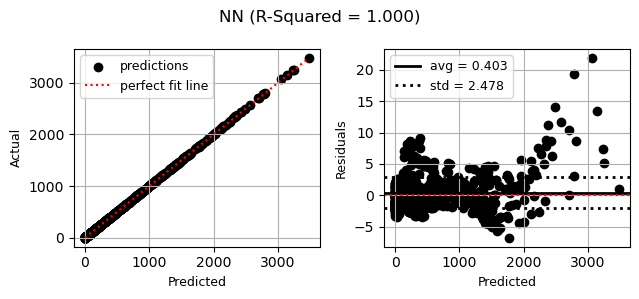

In [14]:
jenn.utils.plot.goodness_of_fit(
    y_true=y_test, 
    y_pred=nn_standard.predict(x_test),
    title="NN"
)

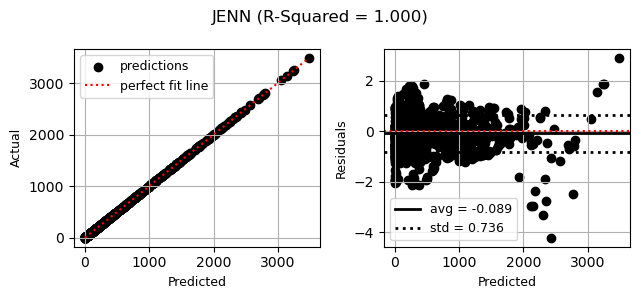

In [15]:
jenn.utils.plot.goodness_of_fit(
    y_true=y_test, 
    y_pred=nn_enhanced.predict(x_test),
    title="JENN"
)

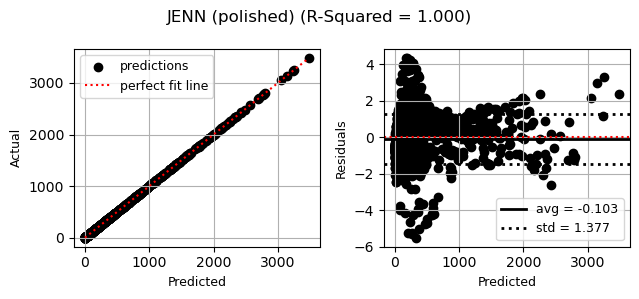

In [16]:
jenn.utils.plot.goodness_of_fit(
    y_true=y_test, 
    y_pred=nn_polished.predict(x_test),
    title="JENN (polished)"
)

### Convergence Histories
It is good practice to check the convergence history in order to decide if we should keep training.

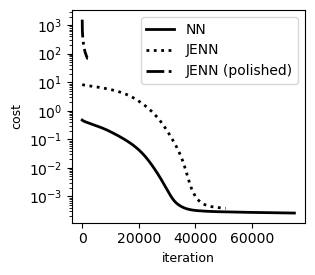

In [17]:
his = jenn.utils.plot.convergence(histories=[nn_standard.history, nn_enhanced.history, nn_polished.history], legend=["NN", "JENN", "JENN (polished)"])
his.savefig("sbo_convergence.pdf")
his

### Surrogate-Based Optimization

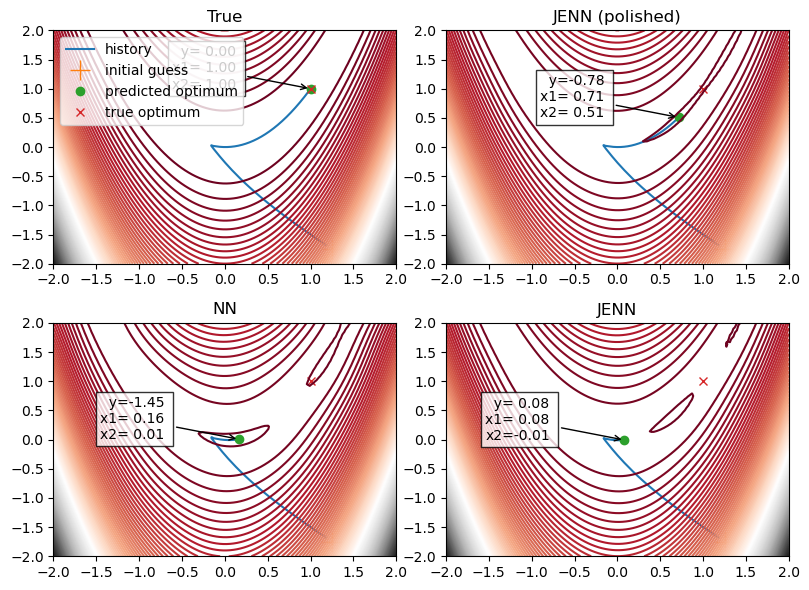

In [18]:
fig = plot_contours(
    nn_standard, 
    nn_enhanced, 
    nn_polished,
    x0=(1.25, -1.75), 
    levels=100, 
    alpha=0.05, 
    beta_1=0.9,
    beta_2=0.99,
    tau=0.5,
    tol=1e-7,
    max_count=2000,
)
fig.savefig("sbo_contours.pdf")
fig